In [1]:
# PONER UN VECTOR DE LA VELOCIDAD SODAR PARA COMPARACION 
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wrf
from wrf import getvar, vinterp, ALL_TIMES, destagger, to_np

In [2]:
expruns = ['20120816_d03_gfs05_p1r1', '20120816_d03_gfs05_p1r3','20120816_d03_gfs05_p1r5',
           '20120816_d03_gfs05_p2r1', '20120816_d03_gfs05_p2r3','20120816_d03_gfs05_p2r5',
           '20120816_d03_nam32_p1r1', '20120816_d03_nam32_p1r3','20120816_d03_nam32_p1r5',
           '20120816_d03_nam32_p2r1', '20120816_d03_nam32_p2r3','20120816_d03_nam32_p2r5' ]
expnames = ['g1r1', 'g1r3', 'g1r5', 'g2r1', 'g2r3', 'g2r5', 
            'n1r1', 'n1r3', 'n1r5', 'n2r1', 'n2r3', 'n2r5']

In [3]:
d1 = '/mnt/sda2/exp6_llj/d03/'
d2 = '../../../../../d03/'

f = d2+expruns[0]+'.nc'
print(f)
ds = Dataset(f)

../../../../../d03/20120816_d03_gfs05_p1r1.nc


In [4]:
wrftime = getvar(ds, "times", timeidx=ALL_TIMES)
utc2loc = np.timedelta64(6,'h')
wrftime10m = pd.to_datetime(wrftime.values)-utc2loc
wrftimeh = pd.to_datetime(wrftime[::3].values)-utc2loc
timelabel = wrftimeh
date1, date2 = wrftimeh[0], wrftimeh[wrftimeh.size-1]
print(wrftimeh.size, date1, date2)

145 2012-08-16 12:00:00 2012-08-19 12:00:00


In [5]:
t1, t2, t3, t4 = '2012-08-16 12:00', '2012-08-17 12:00', '2012-08-18 12:00', '2012-08-19 12:00'
ids = [0,1,2,7,12,17,22,27,32,37,42,47]

sread_w =  pd.read_pickle('sodar_sp.pk')
sread_d =  pd.read_pickle('sodar_dd.pk')
sread_t =  pd.read_pickle('sodar_tv.pk')

sodarw =  sread_w.iloc[:,ids][t1:t4].interpolate().values
sodard =  sread_d.iloc[:,ids][t1:t4].interpolate().values
sodart =  sread_t.iloc[:,ids][t1:t4].interpolate().values

x = sread_w.iloc[:,ids][t1:t4].index
x1 = sread_w.iloc[:,ids][t1:t2].index
x2 = sread_w.iloc[:,ids][t2:t3].index
x3 = sread_w.iloc[:,ids][t3:t4].index

In [6]:
t = 11
lev = 2
print(sodarw[t,lev], sodard[t,lev], sodarw.shape, x[t])

6.5 198.8 (145, 12) 2012-08-16 17:30:00


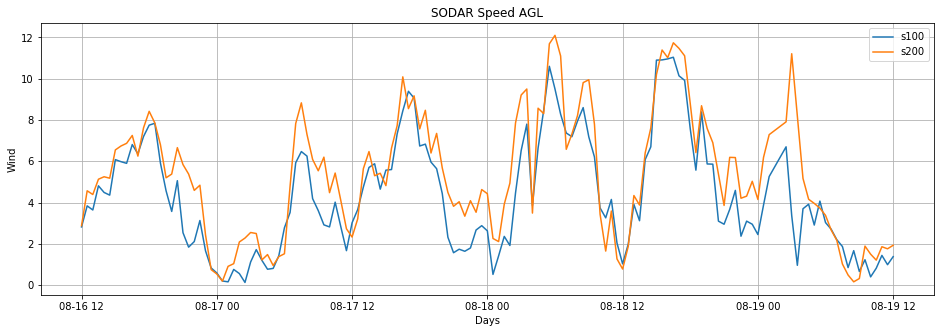

In [7]:
import pandas as pd
fig = plt.figure(figsize=[16,5])

plt.plot(x, sodarw[:,3], label='s100')
plt.plot(x, sodarw[:,5], label='s200')

plt.ylabel('Wind')
plt.xlabel('Days')

plt.grid(True)
plt.legend()

plt.title('SODAR Speed AGL')
figname='wrf_spd_'
#plt.savefig(dirs+figname+'_'+rtimes+'_'+run+'.png', dpi=300)

plt.show()

In [8]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import FormatStrFormatter
# https://matplotlib.org/examples/color/named_colors.html 

import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from wrf import to_np, getvar, smooth2d, get_cartopy, cartopy_xlim, cartopy_ylim, latlon_coords

def levPlot(xp,tt,lev):
        
    zlev = ['m30', '40m', '50m', '100m', '150m', '200m', '250m', '300m', '350m', '400m', '450m', '500m']
    d1, d2 = '/mnt/sda2/exp6_llj/d03/', '../../../../../d03/'
    f = d2+expruns[0]+'.nc'
    ncfile = Dataset(f)
    cart = getvar(ncfile, "ua")
    cart_proj = get_cartopy(cart)

    ua = xr.open_dataset('interp30/'+expnames[xp]+'.nc')['ua30'][tt,lev,:,:]
    va = xr.open_dataset('interp30/'+expnames[xp]+'.nc')['va30'][tt,lev,:,:]
    wa = xr.open_dataset('interp30/'+expnames[xp]+'.nc')['wa30'][tt,lev,:,:]
    pp = xr.open_dataset('interp30/'+expnames[xp]+'.nc')['p30'][tt,lev,:,:]
    zz = xr.open_dataset('interp30/'+expnames[xp]+'.nc')['z30'][tt,lev,:,:]
    tv = xr.open_dataset('interp30/'+expnames[xp]+'.nc')['tv30'][tt,lev,:,:]

    lats, lons = latlon_coords(ua)
    lats, lons = to_np(lats), to_np(lons)
    va = to_np(va)
    ua = to_np(ua)
    wa = to_np(wa)
    pp = to_np(pp)
    tv = to_np(tv)
    UV = np.sqrt(np.power(ua,2) + np.power(va,2))

    fig = plt.figure(figsize=(6,9))
    ax = plt.axes(projection=cart_proj)

    sk = 4
    vmin, vmax = 0, 12.5
    levels = np.arange(vmin,vmax,0.5)
    contf = ax.contourf(lons, lats, UV, 10, levels=levels, vmin=vmin, vmax=vmax, 
                        transform=crs.PlateCarree(), cmap=get_cmap("jet"))
    plt.colorbar(contf, ax=ax, orientation="horizontal", pad=.06)
    CS = plt.contour(lons, lats, tv, transform=crs.PlateCarree(), colors='r')
    plt.clabel(CS, inline=1, fmt='%2.1f', colors='r', fontsize=10)
    Q = ax.quiver(lons[::sk,::sk], lats[::sk,::sk], ua[::sk,::sk], va[::sk,::sk],
                  transform=crs.PlateCarree(), scale=60, pivot='mid')
    ax.quiverkey(Q, X=0.15, Y=1.1, U=5, label=' 5 m/s', labelpos='W')
    
    #ax.scatter(-103.77, 19.285, transform=crs.PlateCarree())
    sw, sd = sodarw[tt,lev], sodard[tt,lev]
    sdr = np.deg2rad(sodard[tt,lev])
    su, sv = np.sin(sdr)*sw, np.cos(sdr)*sw
    print(sw, sd, sdr, x[tt])
    ax.quiver(-264250, -244100, su, sv, scale=60, pivot='mid', color='orange')

    xticks = ax.get_xticks()
    x1, x2 = xticks.min()*(1), xticks.max()*(1.010)
    x1, x2 = -285000.0, -255500.0
    xticks = np.linspace(x1, x2,30)
    xlabel = (lons[15,:][::sk])
    ax.set_xticks(xticks[::sk])
    ax.set_xticklabels(xlabel.round(2), rotation=15)
    yticks = ax.get_yticks()
    y1, y2 = yticks.min()*(.991), yticks.max()*(1.015)
    y1, y2 = -267570.0, -238525.0
    yticks = np.linspace(y1, y2,30)
    ylabel = (lats[:,15][::sk])
    ax.set_yticks(yticks[::sk])
    ax.set_yticklabels(ylabel.round(2), rotation=15)
    plt.title(expnames[xp]+' WRF D03 Wind '+zlev[lev]+'\n Temperature isolines \n Valid time ' +str(wrftimeh[tt]));
    #print(x1, x2, y1, y2)


In [9]:
def isoPPlot(xp,tt,lev):
        
    zlev = ['m30', '40m', '50m', '100m', '150m', '200m', '250m', '300m', '350m', '400m', '450m', '500m']
    d1, d2 = '/mnt/sda2/exp6_llj/d03/', '../../../../../d03/'
    f = d2+expruns[0]+'.nc'
    ncfile = Dataset(f)
    cart = getvar(ncfile, "ua")
    cart_proj = get_cartopy(cart)

    ua = xr.open_dataset('interp30/'+expnames[xp]+'.nc')['ua30'][tt,lev,:,:]
    va = xr.open_dataset('interp30/'+expnames[xp]+'.nc')['va30'][tt,lev,:,:]
    wa = xr.open_dataset('interp30/'+expnames[xp]+'.nc')['wa30'][tt,lev,:,:]
    pp = xr.open_dataset('interp30/'+expnames[xp]+'.nc')['p30'][tt,lev,:,:]
    zz = xr.open_dataset('interp30/'+expnames[xp]+'.nc')['z30'][tt,lev,:,:]
    tv = xr.open_dataset('interp30/'+expnames[xp]+'.nc')['tv30'][tt,lev,:,:]

    lats, lons = latlon_coords(ua)
    lats, lons = to_np(lats), to_np(lons)
    va = to_np(va)
    ua = to_np(ua)
    wa = to_np(wa)
    pp = to_np(pp)
    tv = to_np(tv)
    UV = np.sqrt(np.power(ua,2) + np.power(va,2))
    
    fig = plt.figure(figsize=(6,9))
    ax = plt.axes(projection=cart_proj)

    sk = 4
    vmin, vmax = 25, 35
    levels = np.arange(vmin,vmax,0.5)
    contf = ax.contourf(lons, lats, tv, 10, levels=levels, vmin=vmin, vmax=vmax, 
                        transform=crs.PlateCarree(), cmap=get_cmap("jet"))
    plt.colorbar(contf, ax=ax, orientation="horizontal", pad=.06)
    CS = plt.contour(lons, lats, pp, transform=crs.PlateCarree(), colors='r')
    plt.clabel(CS, inline=1, fmt='%2.1f', colors='r', fontsize=10)
    Q = ax.quiver(lons[::sk,::sk], lats[::sk,::sk], ua[::sk,::sk], va[::sk,::sk],
                  transform=crs.PlateCarree(), scale=60, pivot='mid')
    ax.quiverkey(Q, X=0.15, Y=1.1, U=5, label=' 5 m/s', labelpos='W')
    
    #ax.scatter(-103.77, 19.285, transform=crs.PlateCarree())
    sw, sd = sodarw[tt,lev], sodard[tt,lev]
    sdr = np.deg2rad(sodard[tt,lev])
    su, sv = np.sin(sdr)*sw, np.cos(sdr)*sw
    print(sw, sd, sdr, x[tt])
    ax.quiver(-264250, -244100, su, sv, scale=60, pivot='mid', color='orange')
    xticks = ax.get_xticks()
    x1, x2 = xticks.min()*(1), xticks.max()*(1.010)
    x1, x2 = -285500.0, -255000.0
    xticks = np.linspace(x1, x2,30)
    xlabel = (lons[15,:][::sk])
    ax.set_xticks(xticks[::sk])
    ax.set_xticklabels(xlabel.round(2), rotation=15)
    yticks = ax.get_yticks()
    y1, y2 = yticks.min()*(.991), yticks.max()*(1.015)
    y1, y2 = -267570.0, -238525.0
    yticks = np.linspace(y1, y2,30)
    ylabel = (lats[:,15][::sk])
    ax.set_yticks(yticks[::sk])
    ax.set_yticklabels(ylabel.round(2), rotation=15)
    plt.title(expnames[xp]+' WRF D03 Wind '+zlev[lev]+'\n Pressure isolines, VT Contour Filled \n Valid time ' +str(wrftimeh[tt]));
    #print(x1, x2, y1, y2)
    

2.82 340.5 5.942846103040692 2012-08-17 10:00:00
2.82 340.5 5.942846103040692 2012-08-17 10:00:00


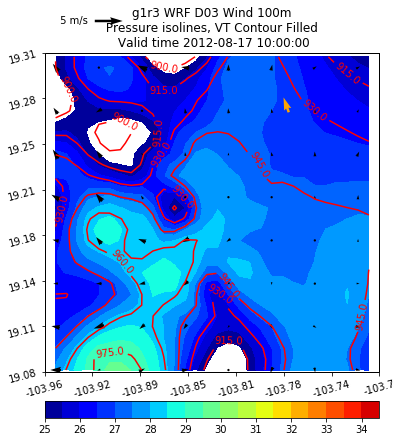

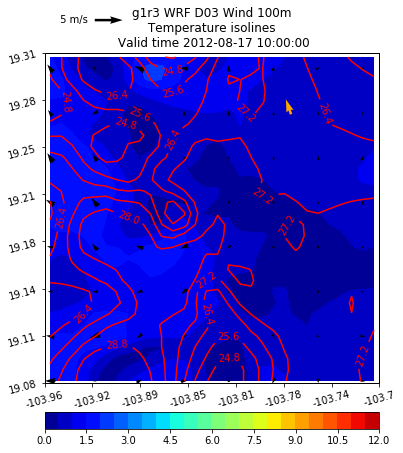

In [10]:
isoPPlot(xp=1,tt=44,lev=3) 
levPlot(xp=1,tt=44,lev=3) 


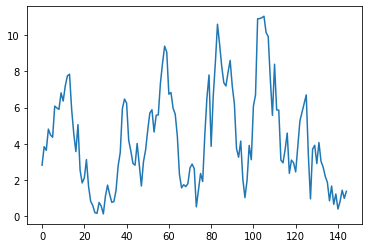

In [11]:
plt.plot(sodarw[:,3])

g1r1
7.33 213.1 3.7192966359999162 2012-08-17 16:00:00
g1r3
7.33 213.1 3.7192966359999162 2012-08-17 16:00:00
g1r5
7.33 213.1 3.7192966359999162 2012-08-17 16:00:00
g2r1
7.33 213.1 3.7192966359999162 2012-08-17 16:00:00
g2r3
7.33 213.1 3.7192966359999162 2012-08-17 16:00:00
g2r5
7.33 213.1 3.7192966359999162 2012-08-17 16:00:00
n1r1
7.33 213.1 3.7192966359999162 2012-08-17 16:00:00
n1r3
7.33 213.1 3.7192966359999162 2012-08-17 16:00:00
n1r5
7.33 213.1 3.7192966359999162 2012-08-17 16:00:00
n2r1
7.33 213.1 3.7192966359999162 2012-08-17 16:00:00
n2r3
7.33 213.1 3.7192966359999162 2012-08-17 16:00:00
n2r5
7.33 213.1 3.7192966359999162 2012-08-17 16:00:00


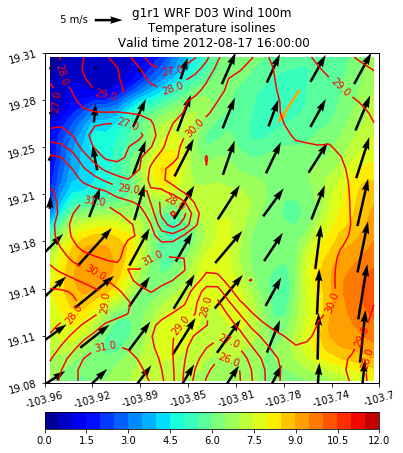

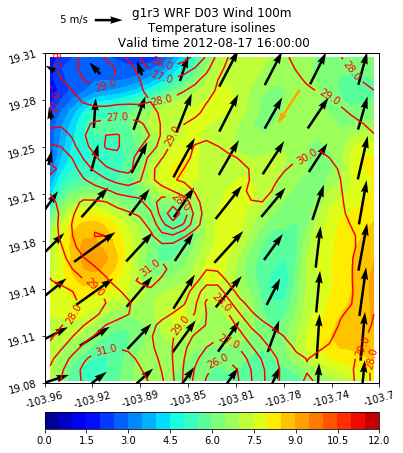

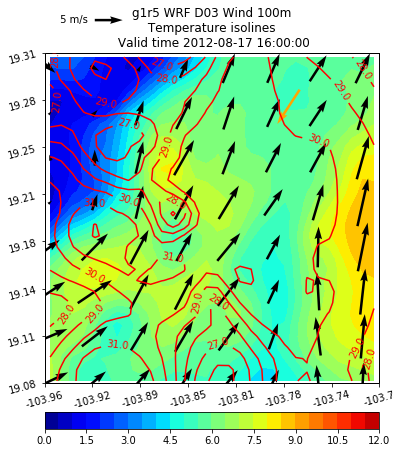

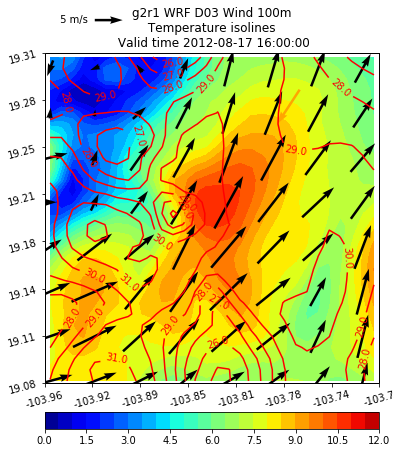

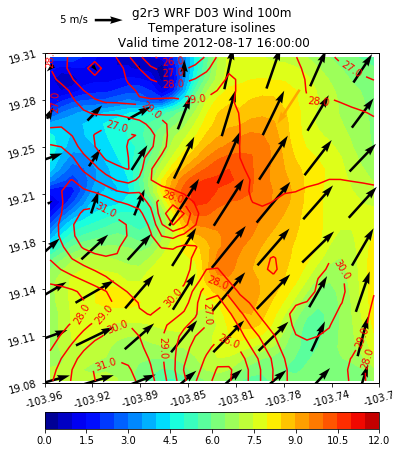

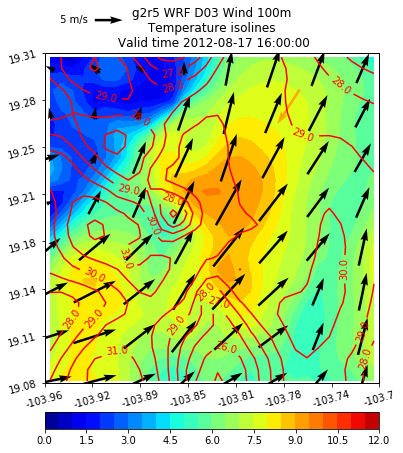

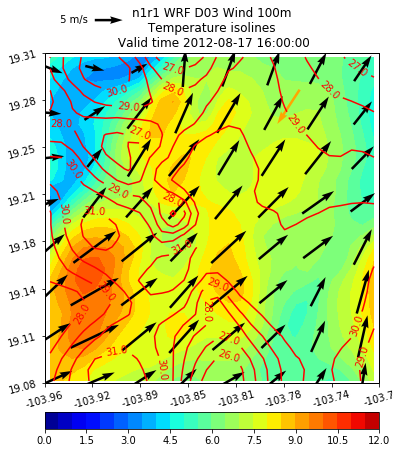

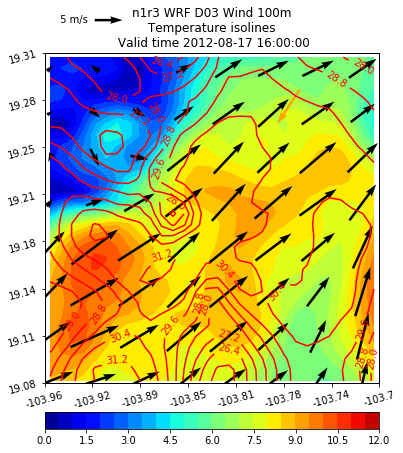

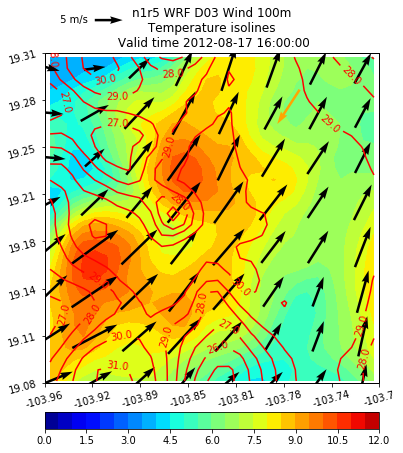

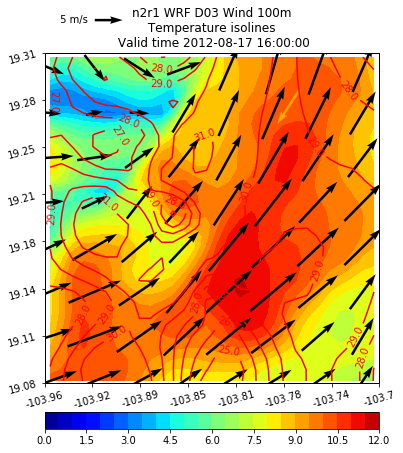

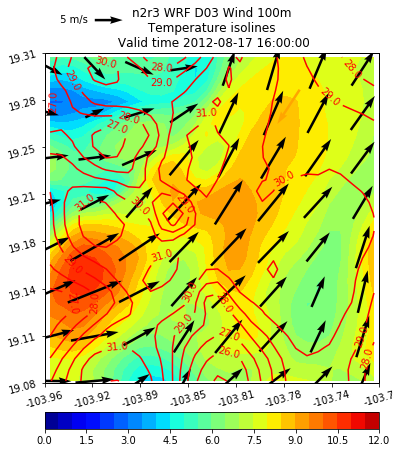

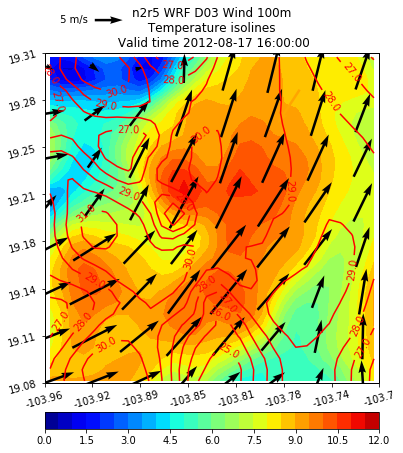

In [12]:
i=0
for xp in expruns:
    xn = expnames[i]
    print(xn)
    levPlot(xp=i,tt=56,lev=3)
    i = i+1

In [13]:
#locs, labels = xticks()            # Get locations and labels
#xticks(ticks, [labels], **kwargs)  # Set locations and labels
#xticks = ax.get_xticks()
#xticks = np.linspace(xticks.min(), xticks.max(),30)
#print(lats[:,15], '\n\n', lons[15,:])
